# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import time
import random

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

import warnings
warnings.filterwarnings('ignore')

# Load Data

In [2]:
category = 'Induk aksara'

train_dir = f"../dataset/preprocessed/{category}/train"
val_dir = f"../dataset/preprocessed/{category}/val"
test_dir = f"../dataset/preprocessed/{category}/test"

IMG_SIZE = (224,224)
BATCH_SIZE = 32
SEED = 42

datagen_train = ImageDataGenerator(
      rescale=1./255,
      rotation_range=30,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

datagen_val = ImageDataGenerator(rescale=1./255)

datagen_test = ImageDataGenerator(rescale=1./255)

print('\nTrain Data:')
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=IMG_SIZE,
                                                    batch_size=BATCH_SIZE,
                                                    shuffle=True)

print('\nValidation Data:')
generator_val = datagen_val.flow_from_directory(directory=val_dir,
                                                target_size=IMG_SIZE,
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)

print('\nTesting Data:')
generator_test = datagen_test.flow_from_directory(directory=test_dir, 
                                                  target_size=IMG_SIZE, 
                                                  batch_size=BATCH_SIZE, 
                                                  shuffle=False)


Train Data:
Found 840 images belonging to 20 classes.

Validation Data:
Found 240 images belonging to 20 classes.



Testing Data:
Found 120 images belonging to 20 classes.


In [3]:
classes_train = generator_train.classes
classes_val = generator_val.classes
classes_test = generator_test.classes

In [4]:
class_names = list(generator_train.class_indices.keys())
num_classes = generator_train.num_classes
print('Classes Names:', class_names)

Classes Names: ['A', 'BA', 'CA', 'DA', 'GA', 'GHA', 'HA', 'JA', 'KA', 'LA', 'MA', 'NA', 'NGA', 'NYA', 'PA', 'RA', 'SA', 'TA', 'WA', 'YA']


# Helper Functions

In [5]:
def path_join(dirname, filenames):
    return [os.path.join(dirname, filename) for filename in filenames]

In [6]:
def load_images(image_paths):
    # Load the images from disk.
    images = [plt.imread(path) for path in image_paths]

    # Convert to a numpy array and return it.
    return np.asarray(images)

In [7]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = class_names[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = class_names[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [8]:
def print_layer_trainable(model):
    for layer in model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

In [9]:
def plot_history(history):
    plt.figure(figsize=(15,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.grid()
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.xticks(np.arange(0, EPOCHS, 2))
    plt.legend(['Train Accuracy', 'Validation Accuracy'])

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid()
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.xticks(np.arange(0, EPOCHS, 2))
    plt.legend(['Train Loss', 'Validation Loss'])

    plt.show()

In [10]:
def plot_confusion_matrix(actual_classes, predicted_classes):
    # Hitung confusion matrix antara label kelas asli dan label kelas prediksi
    conf_matrix = confusion_matrix(actual_classes, predicted_classes)

    # Plot confusion matrix dalam bentuk heatmap
    plt.figure(figsize=(15, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlGnBu', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # Hitung classification report
    report = classification_report(actual_classes, predicted_classes, target_names=class_names)

    # Tampilkan classification report
    print("Classification Report:")
    print(report)

In [11]:
def example_success(actual_classes, predicted_classes):
    
    # Boolean array whether the predicted class is incorrect.
    correct = (predicted_classes == actual_classes)

    # Get the file-paths for images that were correctly classified.
    image_paths = np.array(image_paths_test)[correct]

    # Randomly .
    i = random.randint(0, len(image_paths)-9)
    j = i + 9

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[i:j])
    
    # # Get the predicted classes for those images.
    class_pred = predicted_classes[correct] 

    # Get the true classes for those images.
    cls_true = actual_classes[correct]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[i:j],
                cls_pred=class_pred[i:j])

In [12]:
def example_errors(actual_classes, predicted_classes):
    # Boolean array whether the predicted class is incorrect.
    incorrect = (predicted_classes != actual_classes)

    # Get the file-paths for images that were incorrectly classified.
    image_paths = np.array(image_paths_test)[incorrect]

    # Load the first 9 images.
    images = load_images(image_paths=image_paths[0:9])
    
    # # Get the predicted classes for those images.
    class_pred = predicted_classes[incorrect] 

    # Get the true classes for those images.
    cls_true = actual_classes[incorrect]
    
    # Plot the 9 images we have loaded and their corresponding classes.
    # We have only loaded 9 images so there is no need to slice those again.
    plot_images(images=images,
                cls_true=cls_true[0:9],
                cls_pred=class_pred[0:9])

In [13]:
def grid_search_results(gs):
    print(f"Fitting {gs.n_splits_} folds for each of {len(gs.cv_results_['params'])} candidates, totalling {len(gs.cv_results_['params']) * gs.n_splits_} fits")
    for i, param in enumerate(gs.cv_results_['params']):
        print(f"Parameters: {param}")
        for j in range(gs.n_splits_):
            accuracy = gs.cv_results_[f'split{j}_test_accuracy'][i]
            neg_log_loss = gs.cv_results_[f'split{j}_test_neg_log_loss'][i]
            print(f"[CV {j+1}/{gs.n_splits_}] accuracy: (test={accuracy:.3f}) log_loss: (test={neg_log_loss*-1:.3f})")
        print()
    print('Best Parameter:', gs.best_params_, 'with average accuracy score:', gs.best_score_.round(4))

# Plot Sample of Images

In [14]:
image_paths_train = path_join(train_dir, generator_train.filenames)
image_paths_val = path_join(val_dir, generator_val.filenames)
image_paths_test = path_join(test_dir, generator_test.filenames)

train_images = load_images(image_paths_train)
val_images = load_images(image_paths_val)
test_images = load_images(image_paths_test)

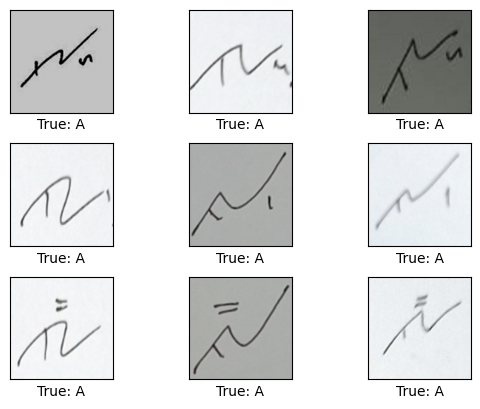

In [15]:
# Plot the images and labels using our helper-function above.
plot_images(images=train_images, cls_true=classes_train, smooth=True)

# Modeling Experiment

In [16]:
accuracy_results  = {}

## VGG-16 Pretained Model

In [17]:
vgg16_pretrained = VGG16(include_top=False, 
                   input_shape=(224, 224, 3),
                   pooling='avg',
                   weights='imagenet')

vgg16_pretrained.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Build a Model

In [18]:
def vgg16_new_model(name='vgg16_new_model'):
    
    m = vgg16_pretrained.output
    m = BatchNormalization()(m)
    m = Dense(512, activation='relu', name='fc1')(m)
    m = Dropout(0.5)(m)
    predictions = Dense(num_classes, activation='softmax', name='prediction')(m)

    model = Model(inputs=vgg16_pretrained.input, outputs=predictions, name=name)
    return model

In [19]:
vgg16_m = vgg16_new_model()
vgg16_m.summary()

Model: "vgg16_new_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)   

In [20]:
print_layer_trainable(vgg16_m)

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	global_average_pooling2d
True:	batch_normalization
True:	fc1
True:	dropout
True:	prediction


In [21]:
for layer in vgg16_m.layers:
    layer.trainable = False
    if layer.name.startswith('global_average_pooling2d'):
        break

vgg16_m.summary()

Model: "vgg16_new_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)   

In [22]:
print_layer_trainable(vgg16_m)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
False:	block5_conv1
False:	block5_conv2
False:	block5_conv3
False:	block5_pool
False:	global_average_pooling2d
True:	batch_normalization
True:	fc1
True:	dropout
True:	prediction


### Set Paramater Values

In [23]:
OPTIMIZER=Adam(learning_rate=0.001)
LOSS='categorical_crossentropy'
METRICS=['categorical_accuracy']

STEPS_PER_EPOCH = generator_train.n/BATCH_SIZE
VALIDATION_STEPS = generator_val.n/BATCH_SIZE
EPOCHS = 30

model_name = "vgg16_m"
filepath = f'../saved_models/{category}/{model_name}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

CALLBACKS = [reduce_lr, checkpoint, early_stop]

### Training the Model

In [24]:
vgg16_m.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=METRICS)

start_time = time.time()
h_vgg16 = vgg16_m.fit_generator(generator_train,
                                epochs=EPOCHS, 
                                steps_per_epoch=STEPS_PER_EPOCH, 
                                validation_data=generator_val, 
                                validation_steps=VALIDATION_STEPS, 
                                callbacks=CALLBACKS)
end_time = time.time()

Epoch 1/30
26/26 [==============================] - 18s 373ms/step - loss: 2.7293 - categorical_accuracy: 0.1988 - val_loss: 2.9334 - val_categorical_accuracy: 0.0542 - lr: 0.0010
Epoch 2/30
26/26 [==============================] - 6s 225ms/step - loss: 1.8185 - categorical_accuracy: 0.4679 - val_loss: 2.8352 - val_categorical_accuracy: 0.1542 - lr: 0.0010
Epoch 3/30
26/26 [==============================] - 6s 227ms/step - loss: 1.3804 - categorical_accuracy: 0.5833 - val_loss: 2.7386 - val_categorical_accuracy: 0.1667 - lr: 0.0010
Epoch 4/30
26/26 [==============================] - 6s 233ms/step - loss: 1.2086 - categorical_accuracy: 0.6488 - val_loss: 2.6154 - val_categorical_accuracy: 0.2667 - lr: 0.0010
Epoch 5/30
26/26 [==============================] - 6s 224ms/step - loss: 1.0087 - categorical_accuracy: 0.7012 - val_loss: 2.4961 - val_categorical_accuracy: 0.2792 - lr: 0.0010
Epoch 6/30
26/26 [==============================] - 6s 222ms/step - loss: 0.8487 - categorical_accuracy:

### Model Evaluation

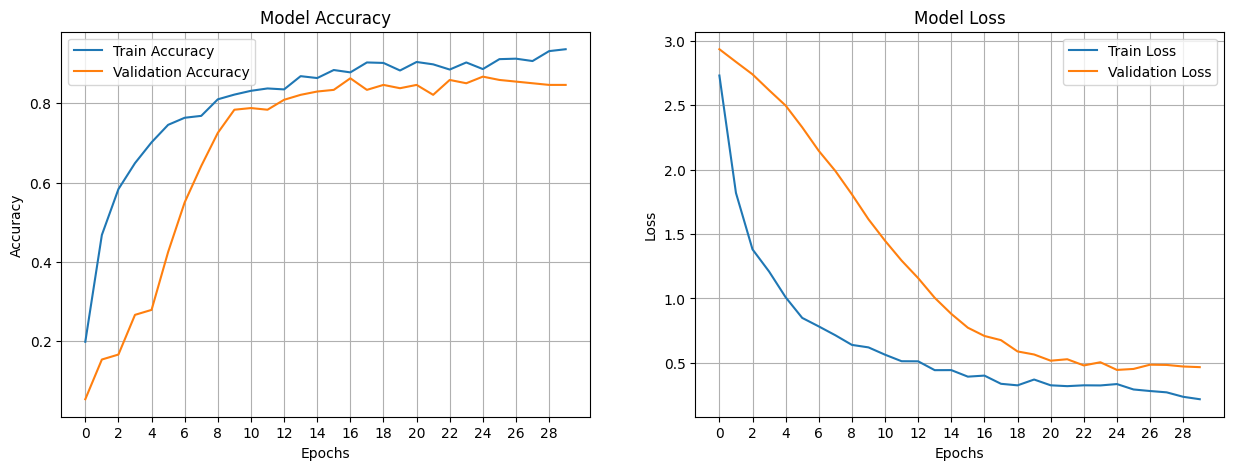

In [25]:
plot_history(h_vgg16)

In [26]:
model_name = 'vgg16_m'
model_path = f"../saved_models/{category}/{model_name}.hdf5"
vgg16_m= load_model(model_path)

train_loss, train_accuracy = vgg16_m.evaluate_generator(generator_train)
print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = vgg16_m.evaluate_generator(generator_val)
print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.13111045956611633
Training Accuracy: 0.9785714149475098
------------------------------------------------
Validation Loss: 0.4450441598892212
Validation Accuracy: 0.8666666746139526
------------------------------------------------
Training Times: 189.14196372032166 seconds


### Prediction on Test Dataset

Predicting Times: 4.056602239608765 seconds


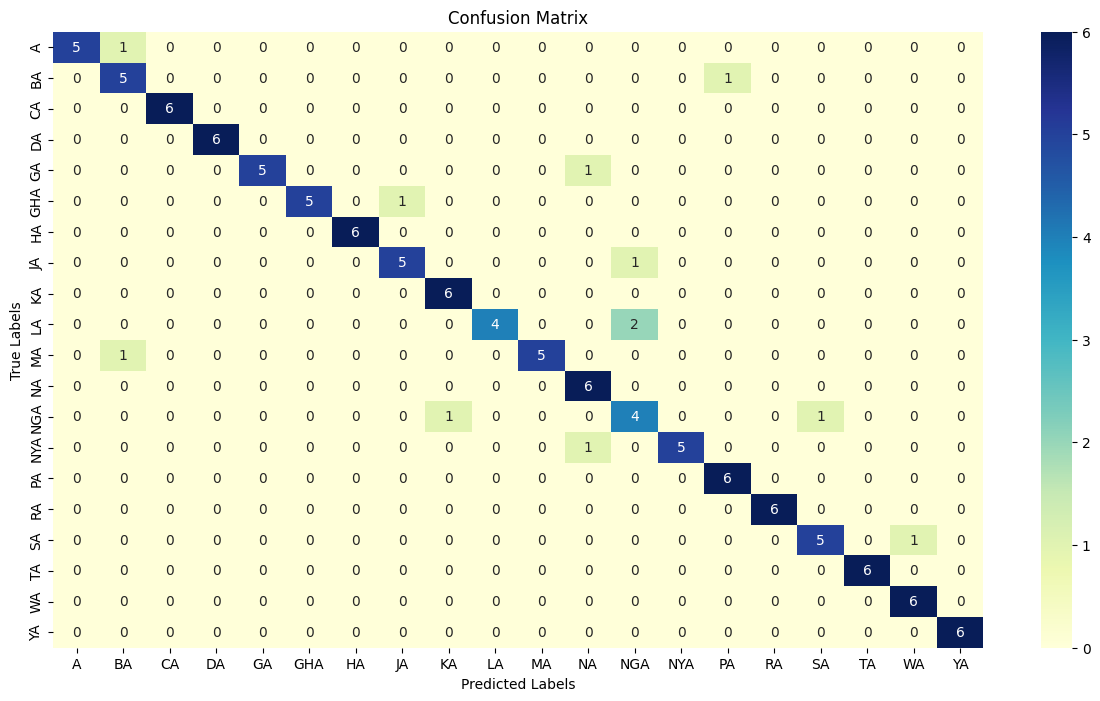

Classification Report:
              precision    recall  f1-score   support

           A       1.00      0.83      0.91         6
          BA       0.71      0.83      0.77         6
          CA       1.00      1.00      1.00         6
          DA       1.00      1.00      1.00         6
          GA       1.00      0.83      0.91         6
         GHA       1.00      0.83      0.91         6
          HA       1.00      1.00      1.00         6
          JA       0.83      0.83      0.83         6
          KA       0.86      1.00      0.92         6
          LA       1.00      0.67      0.80         6
          MA       1.00      0.83      0.91         6
          NA       0.75      1.00      0.86         6
         NGA       0.57      0.67      0.62         6
         NYA       1.00      0.83      0.91         6
          PA       0.86      1.00      0.92         6
          RA       1.00      1.00      1.00         6
          SA       0.83      0.83      0.83         6
    

In [27]:
# Reset generator
generator_test.reset()

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
predictions = vgg16_m.predict_generator(generator_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_loss, test_accuracy = vgg16_m.evaluate_generator(generator_test)

# Ubah prediksi yang diperoleh menjadi label kelas menggunakan invers dari one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)
plot_confusion_matrix(classes_test, predicted_classes)

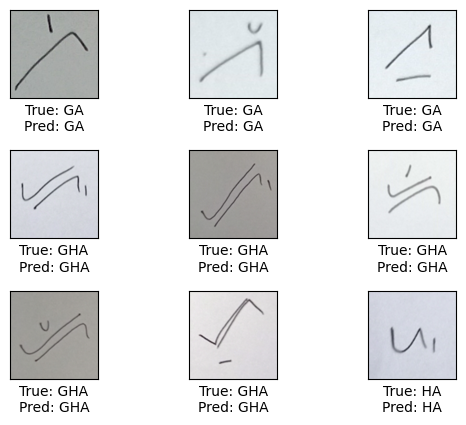

In [28]:
example_success(classes_test, predicted_classes)

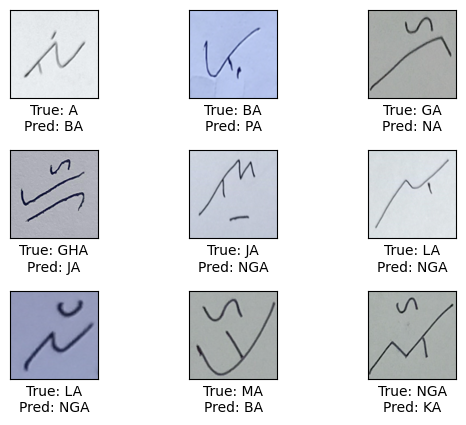

In [29]:
example_errors(classes_test, predicted_classes)

In [30]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]

## VGG-16 with Fine Tuning

### Build a Moodel

In [31]:
vgg16_finetune_m = vgg16_new_model(name='vgg16_finetune_model')

for layer in vgg16_finetune_m.layers:
    layer.trainable = True

vgg16_finetune_m.summary()

Model: "vgg16_finetune_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 12

In [32]:
print_layer_trainable(vgg16_finetune_m)

True:	input_1
True:	block1_conv1
True:	block1_conv2
True:	block1_pool
True:	block2_conv1
True:	block2_conv2
True:	block2_pool
True:	block3_conv1
True:	block3_conv2
True:	block3_conv3
True:	block3_pool
True:	block4_conv1
True:	block4_conv2
True:	block4_conv3
True:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	global_average_pooling2d
True:	batch_normalization_1
True:	fc1
True:	dropout_1
True:	prediction


In [33]:
for layer in vgg16_finetune_m.layers:
    if layer.name.startswith('block5_conv1'):
        break
    layer.trainable = False

vgg16_finetune_m.summary()

Model: "vgg16_finetune_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 12

In [34]:
print_layer_trainable(vgg16_finetune_m)

False:	input_1
False:	block1_conv1
False:	block1_conv2
False:	block1_pool
False:	block2_conv1
False:	block2_conv2
False:	block2_pool
False:	block3_conv1
False:	block3_conv2
False:	block3_conv3
False:	block3_pool
False:	block4_conv1
False:	block4_conv2
False:	block4_conv3
False:	block4_pool
True:	block5_conv1
True:	block5_conv2
True:	block5_conv3
True:	block5_pool
True:	global_average_pooling2d
True:	batch_normalization_1
True:	fc1
True:	dropout_1
True:	prediction


### Set Parameter Values

In [35]:
OPTIMIZER=Adam(learning_rate=0.001)
LOSS='categorical_crossentropy'
METRICS=['categorical_accuracy']

STEPS_PER_EPOCH = generator_train.n/BATCH_SIZE
VALIDATION_STEPS = generator_val.n/BATCH_SIZE
EPOCHS = 30

model_name = "vgg16_finetune_m"
filepath = f'../saved_models/{category}/{model_name}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

CALLBACKS = [reduce_lr, checkpoint, early_stop]

### Training the Model

In [36]:
vgg16_finetune_m.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=METRICS)

start_time = time.time()
h_vgg16_tune = vgg16_finetune_m.fit_generator(generator_train,
                                              epochs=EPOCHS, 
                                              steps_per_epoch=STEPS_PER_EPOCH, 
                                              validation_data=generator_val, 
                                              validation_steps=VALIDATION_STEPS, 
                                              callbacks=CALLBACKS)
end_time = time.time()

Epoch 1/30
26/26 [==============================] - 8s 239ms/step - loss: 2.8920 - categorical_accuracy: 0.1214 - val_loss: 15.4962 - val_categorical_accuracy: 0.1167 - lr: 0.0010
Epoch 2/30
26/26 [==============================] - 6s 218ms/step - loss: 2.3746 - categorical_accuracy: 0.2274 - val_loss: 13.4307 - val_categorical_accuracy: 0.0875 - lr: 0.0010
Epoch 3/30
26/26 [==============================] - 6s 224ms/step - loss: 2.0034 - categorical_accuracy: 0.3429 - val_loss: 11.3105 - val_categorical_accuracy: 0.1458 - lr: 0.0010
Epoch 4/30
26/26 [==============================] - 6s 216ms/step - loss: 1.5725 - categorical_accuracy: 0.4988 - val_loss: 6.8588 - val_categorical_accuracy: 0.1750 - lr: 0.0010
Epoch 5/30
26/26 [==============================] - 6s 213ms/step - loss: 1.1817 - categorical_accuracy: 0.6036 - val_loss: 6.3066 - val_categorical_accuracy: 0.1625 - lr: 0.0010
Epoch 6/30
26/26 [==============================] - 6s 219ms/step - loss: 0.8069 - categorical_accurac

### Model Evaluation

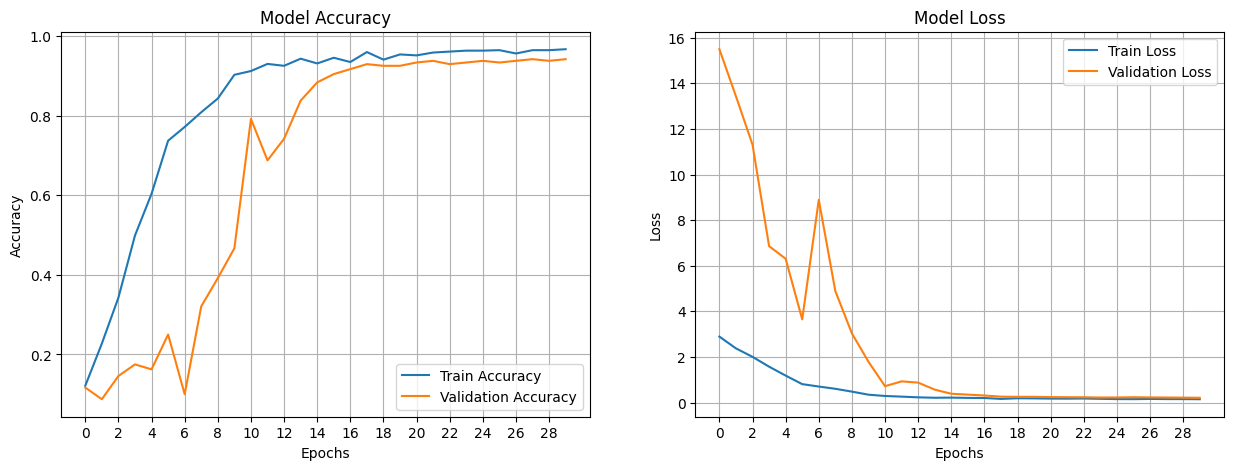

In [37]:
plot_history(h_vgg16_tune)

In [38]:
model_name = 'vgg16_finetune_m'
model_path = f"../saved_models/{category}/{model_name}.hdf5"
vgg16_finetune_m = load_model(model_path)

train_loss, train_accuracy = vgg16_finetune_m.evaluate_generator(generator_train)
print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = vgg16_finetune_m.evaluate_generator(generator_val)
print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.08680467307567596
Training Accuracy: 0.9857142567634583
------------------------------------------------
Validation Loss: 0.21965959668159485
Validation Accuracy: 0.9416666626930237
------------------------------------------------
Training Times: 175.49491167068481 seconds


### Prediction of Test Dataset

Predicting Times: 0.6207723617553711 seconds


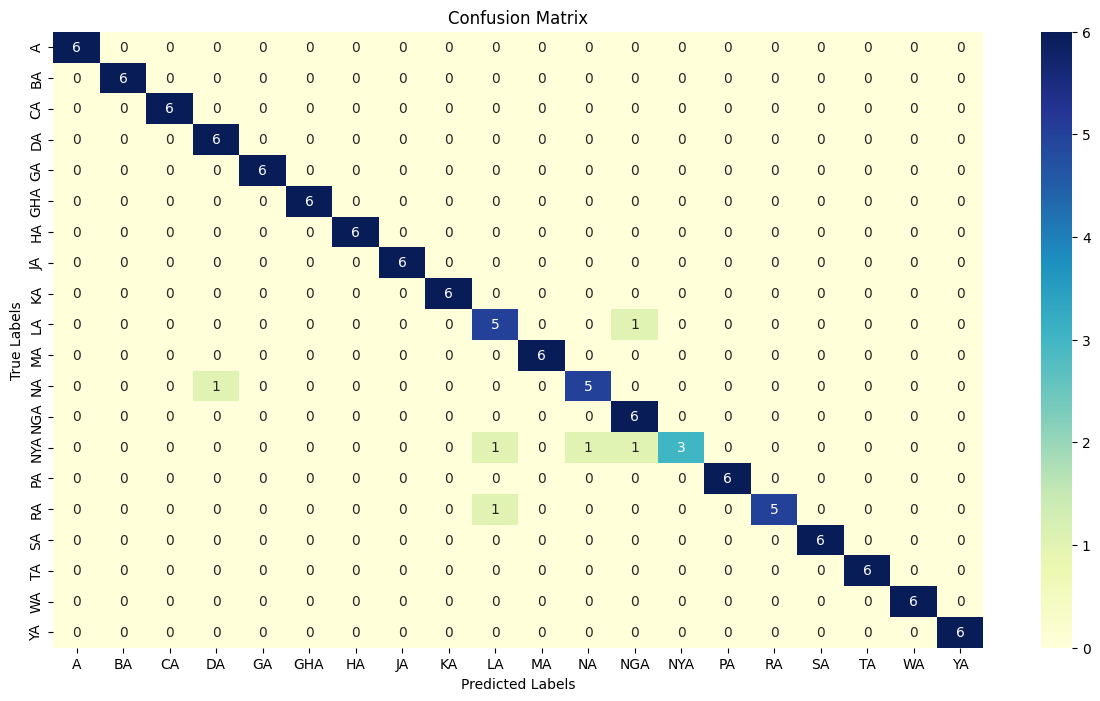

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         6
          BA       1.00      1.00      1.00         6
          CA       1.00      1.00      1.00         6
          DA       0.86      1.00      0.92         6
          GA       1.00      1.00      1.00         6
         GHA       1.00      1.00      1.00         6
          HA       1.00      1.00      1.00         6
          JA       1.00      1.00      1.00         6
          KA       1.00      1.00      1.00         6
          LA       0.71      0.83      0.77         6
          MA       1.00      1.00      1.00         6
          NA       0.83      0.83      0.83         6
         NGA       0.75      1.00      0.86         6
         NYA       1.00      0.50      0.67         6
          PA       1.00      1.00      1.00         6
          RA       1.00      0.83      0.91         6
          SA       1.00      1.00      1.00         6
    

In [39]:
# Reset generator
generator_test.reset()

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
predictions = vgg16_finetune_m.predict_generator(generator_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_loss, test_accuracy = vgg16_finetune_m.evaluate_generator(generator_test)

# Ubah prediksi yang diperoleh menjadi label kelas menggunakan invers dari one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)
plot_confusion_matrix(classes_test, predicted_classes)

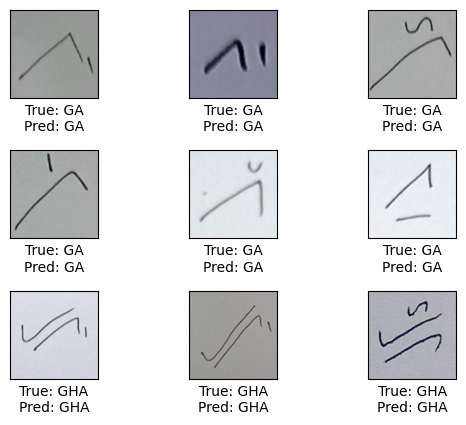

In [40]:
example_success(classes_test, predicted_classes)

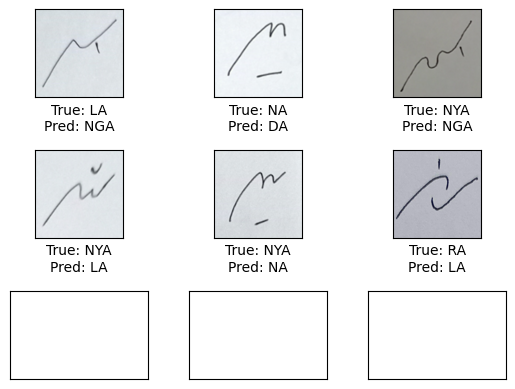

In [41]:
example_errors(classes_test, predicted_classes)

In [42]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]

## VGG-16 Pretrained as Features Extraction + Random Forest as Classifier

### Build the Model for Features Extraction

In [43]:
vgg16_pretrained_fe = vgg16_m.layers[-5]

vgg16_pretrained_fe = Model(inputs=vgg16_m.input,
                            outputs=vgg16_pretrained_fe.output)

for layer in vgg16_pretrained_fe.layers:
    layer.trainable = False

vgg16_pretrained_fe.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### Hyperparameter Tunning GridSearchCV

In [44]:
X_train = vgg16_pretrained_fe.predict(train_images)
X_val = vgg16_pretrained_fe.predict(val_images)

y_train, y_val = classes_train, classes_val

X_train_val = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)], ignore_index=True).values
y_train_val = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)], ignore_index=True).values.reshape(-1)

8/8 [==============================] - 1s 91ms/step


In [45]:
params = {
    'n_estimators' : [100, 200, 300]
}

gs = GridSearchCV(estimator=RandomForestClassifier(random_state=SEED),
                  param_grid=params,
                  scoring=['accuracy', 'neg_log_loss'],
                  refit='accuracy',
                  cv=5,
                  n_jobs=-1)

gs.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300]}, refit='accuracy',
             scoring=['accuracy', 'neg_log_loss'])

In [46]:
grid_search_results(gs)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Parameters: {'n_estimators': 100}
[CV 1/5] accuracy: (test=0.644) log_loss: (test=1.764)
[CV 2/5] accuracy: (test=0.755) log_loss: (test=1.581)
[CV 3/5] accuracy: (test=0.769) log_loss: (test=1.542)
[CV 4/5] accuracy: (test=0.741) log_loss: (test=1.553)
[CV 5/5] accuracy: (test=0.731) log_loss: (test=1.539)

Parameters: {'n_estimators': 200}
[CV 1/5] accuracy: (test=0.676) log_loss: (test=1.742)
[CV 2/5] accuracy: (test=0.792) log_loss: (test=1.576)
[CV 3/5] accuracy: (test=0.806) log_loss: (test=1.524)
[CV 4/5] accuracy: (test=0.782) log_loss: (test=1.545)
[CV 5/5] accuracy: (test=0.769) log_loss: (test=1.525)

Parameters: {'n_estimators': 300}
[CV 1/5] accuracy: (test=0.671) log_loss: (test=1.731)
[CV 2/5] accuracy: (test=0.810) log_loss: (test=1.569)
[CV 3/5] accuracy: (test=0.787) log_loss: (test=1.522)
[CV 4/5] accuracy: (test=0.806) log_loss: (test=1.549)
[CV 5/5] accuracy: (test=0.806) log_loss: (test=1.522)

Best Param

### Training the model

In [47]:
start_time = time.time()
rf_classifier = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators'], random_state=SEED)
rf_classifier.fit(X_train, y_train)
end_time = time.time()

### Model Evaluation

In [48]:
model_name = 'vgg16_pretraind_rf_m'
model_path = f"../saved_models/{category}/{model_name}.pkl"
joblib.dump(rf_classifier, model_path)

vgg16_pretraind_rf_m = joblib.load(model_path)

In [49]:
# Predictions and evaluation on training set
train_predictions = vgg16_pretraind_rf_m.predict(X_train)
train_predictions_prob = vgg16_pretraind_rf_m.predict_proba(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_loss = log_loss(y_train, train_predictions_prob)

# Predictions and evaluation on validation set
val_predictions = vgg16_pretraind_rf_m.predict(X_val)
val_predictions_prob = vgg16_pretraind_rf_m.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_predictions_prob)

print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.3340227610990132
Training Accuracy: 1.0
------------------------------------------------
Validation Loss: 1.5671596216641945
Validation Accuracy: 0.775
------------------------------------------------
Training Times: 3.099581480026245 seconds


### Prediction of Test Dataset

4/4 [==============================] - 0s 115ms/step
Predicting Times: 0.5285093784332275 seconds


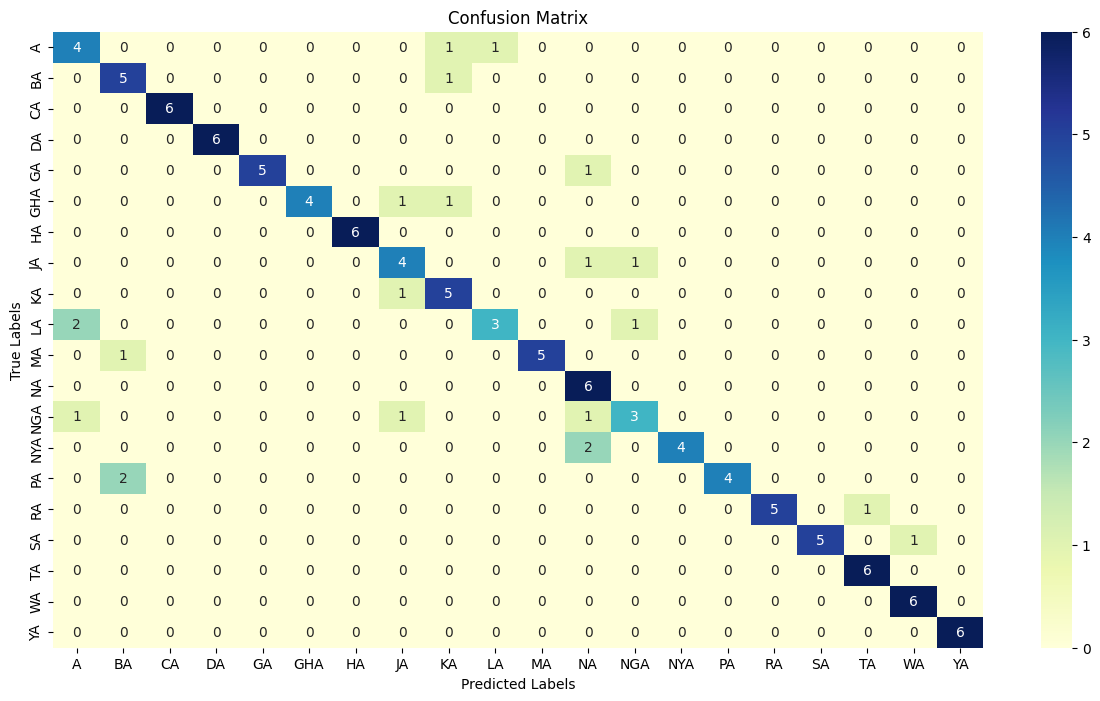

Classification Report:
              precision    recall  f1-score   support

           A       0.57      0.67      0.62         6
          BA       0.62      0.83      0.71         6
          CA       1.00      1.00      1.00         6
          DA       1.00      1.00      1.00         6
          GA       1.00      0.83      0.91         6
         GHA       1.00      0.67      0.80         6
          HA       1.00      1.00      1.00         6
          JA       0.57      0.67      0.62         6
          KA       0.62      0.83      0.71         6
          LA       0.75      0.50      0.60         6
          MA       1.00      0.83      0.91         6
          NA       0.55      1.00      0.71         6
         NGA       0.60      0.50      0.55         6
         NYA       1.00      0.67      0.80         6
          PA       1.00      0.67      0.80         6
          RA       1.00      0.83      0.91         6
          SA       1.00      0.83      0.91         6
    

In [50]:
y_test = classes_test

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
X_test = vgg16_pretrained_fe.predict(test_images)
predictions = vgg16_pretraind_rf_m.predict(X_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_accuracy = accuracy_score(y_test, predictions)

plot_confusion_matrix(y_test, predictions)

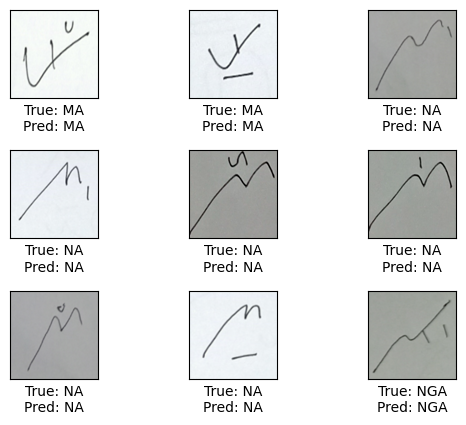

In [51]:
example_success(y_test, predictions)

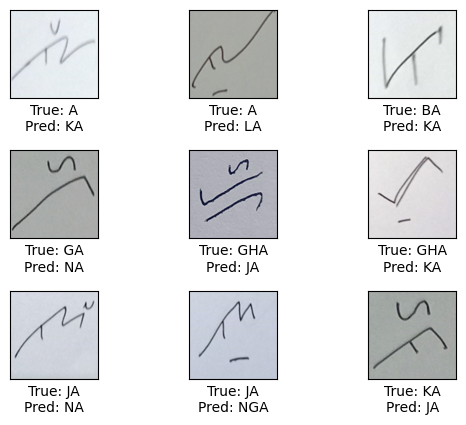

In [52]:
example_errors(y_test, predictions)

In [53]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]

## VGG-16 Finetuning as Features Extraction + Random Forest as Classifier

### Build the Model for Features Extraction

In [54]:
vgg16_ft_fe = vgg16_finetune_m.layers[-5]

vgg16_ft_fe = Model(inputs=vgg16_finetune_m.input,
                    outputs=vgg16_ft_fe.output)

for layer in vgg16_ft_fe.layers:
    layer.trainable = False

vgg16_ft_fe.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Hyperparameter Tunning GridSearchCV

In [55]:
X_train = vgg16_ft_fe.predict(train_images)
X_val = vgg16_ft_fe.predict(val_images)

y_train, y_val = classes_train, classes_val

X_train_val = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)], ignore_index=True).values
y_train_val = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)], ignore_index=True).values.reshape(-1)

8/8 [==============================] - 1s 88ms/step


In [56]:
params = {
    'n_estimators' : [100, 200, 300]
}

gs = GridSearchCV(estimator=RandomForestClassifier(random_state=SEED),
                  param_grid=params,
                  scoring=['accuracy', 'neg_log_loss'],
                  refit='accuracy',
                  cv=5,
                  n_jobs=-1)

gs.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300]}, refit='accuracy',
             scoring=['accuracy', 'neg_log_loss'])

In [57]:
grid_search_results(gs)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Parameters: {'n_estimators': 100}
[CV 1/5] accuracy: (test=0.981) log_loss: (test=0.314)
[CV 2/5] accuracy: (test=0.991) log_loss: (test=0.232)
[CV 3/5] accuracy: (test=0.995) log_loss: (test=0.248)
[CV 4/5] accuracy: (test=0.968) log_loss: (test=0.331)
[CV 5/5] accuracy: (test=0.963) log_loss: (test=0.363)

Parameters: {'n_estimators': 200}
[CV 1/5] accuracy: (test=0.986) log_loss: (test=0.314)
[CV 2/5] accuracy: (test=0.991) log_loss: (test=0.228)
[CV 3/5] accuracy: (test=0.995) log_loss: (test=0.253)
[CV 4/5] accuracy: (test=0.968) log_loss: (test=0.320)
[CV 5/5] accuracy: (test=0.954) log_loss: (test=0.365)

Parameters: {'n_estimators': 300}
[CV 1/5] accuracy: (test=0.986) log_loss: (test=0.315)
[CV 2/5] accuracy: (test=0.995) log_loss: (test=0.226)
[CV 3/5] accuracy: (test=0.995) log_loss: (test=0.253)
[CV 4/5] accuracy: (test=0.968) log_loss: (test=0.319)
[CV 5/5] accuracy: (test=0.963) log_loss: (test=0.366)

Best Param

### Training the model

In [58]:
start_time = time.time()
rf_classifier = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators'], random_state=SEED)
rf_classifier.fit(X_train, y_train)
end_time = time.time()

### Model Evaluation

In [59]:
model_name = 'vgg16_finetune_rf_m'
model_path = f"../saved_models/{category}/{model_name}.pkl"
joblib.dump(rf_classifier, model_path)

vgg16_finetune_rf_m = joblib.load(model_path)

In [60]:
# Predictions and evaluation on training set
train_predictions = vgg16_finetune_rf_m.predict(X_train)
train_predictions_prob = vgg16_finetune_rf_m.predict_proba(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_loss = log_loss(y_train, train_predictions_prob)

# Predictions and evaluation on validation set
val_predictions = vgg16_finetune_rf_m.predict(X_val)
val_predictions_prob = vgg16_finetune_rf_m.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_predictions_prob)

print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.08365636204156927
Training Accuracy: 1.0
------------------------------------------------
Validation Loss: 0.40040298352559656
Validation Accuracy: 0.95
------------------------------------------------
Training Times: 0.9348466396331787 seconds


### Prediction of Test Dataset

4/4 [==============================] - 0s 133ms/step
Predicting Times: 0.5641112327575684 seconds


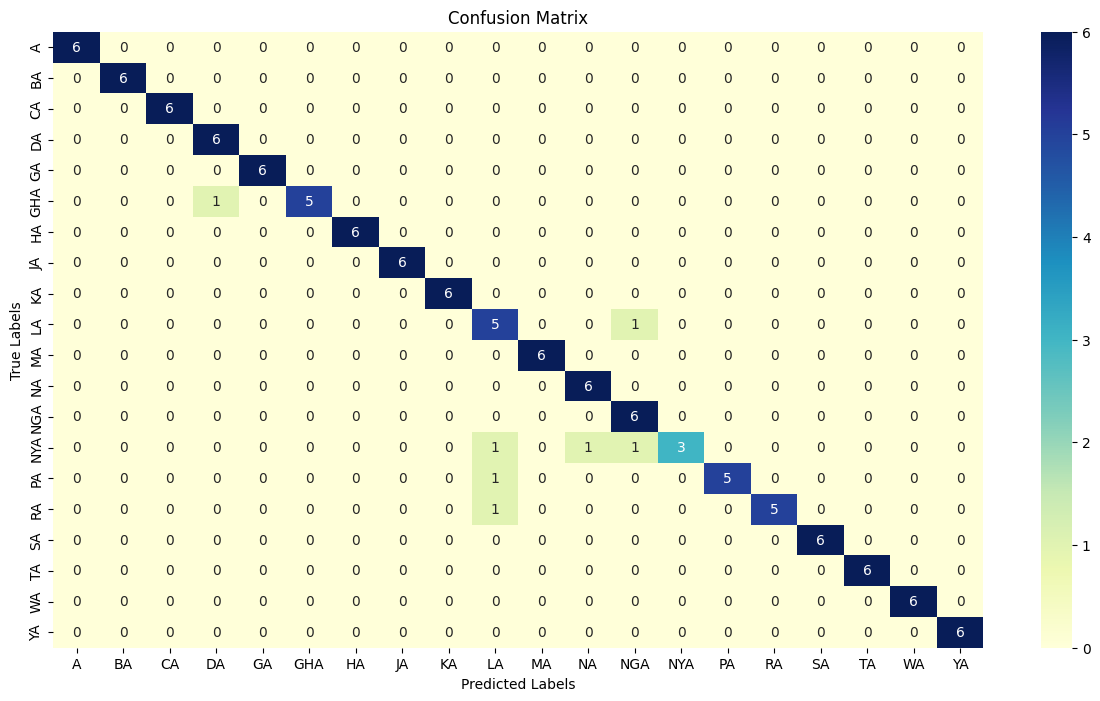

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         6
          BA       1.00      1.00      1.00         6
          CA       1.00      1.00      1.00         6
          DA       0.86      1.00      0.92         6
          GA       1.00      1.00      1.00         6
         GHA       1.00      0.83      0.91         6
          HA       1.00      1.00      1.00         6
          JA       1.00      1.00      1.00         6
          KA       1.00      1.00      1.00         6
          LA       0.62      0.83      0.71         6
          MA       1.00      1.00      1.00         6
          NA       0.86      1.00      0.92         6
         NGA       0.75      1.00      0.86         6
         NYA       1.00      0.50      0.67         6
          PA       1.00      0.83      0.91         6
          RA       1.00      0.83      0.91         6
          SA       1.00      1.00      1.00         6
    

In [61]:
y_test = classes_test

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
X_test = vgg16_ft_fe.predict(test_images)
predictions = vgg16_finetune_rf_m.predict(X_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_accuracy = accuracy_score(y_test, predictions)
plot_confusion_matrix(y_test, predictions)

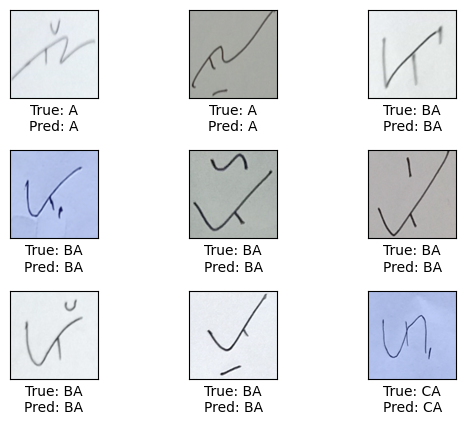

In [62]:
example_success(y_test, predictions)

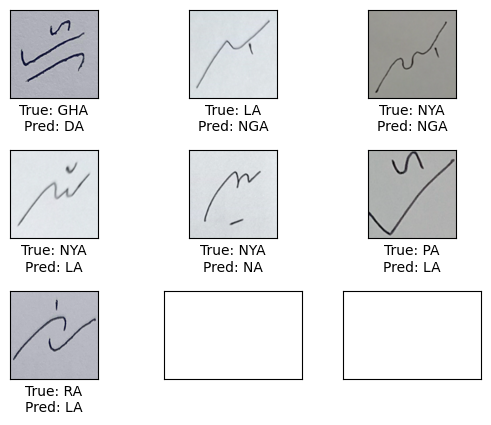

In [63]:
example_errors(y_test, predictions)

In [64]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]

## ResNet-50 Pretrained

In [65]:
resnet50_pretrained = ResNet50V2(include_top=False, 
                                 input_shape=(224, 224, 3),
                                 pooling='avg',
                                 weights='imagenet')

resnet50_pretrained.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                         

### Build a Model

In [66]:
def resnet50_new_model(name='resnet50_new_model'):
    
    m = resnet50_pretrained.output
    m = BatchNormalization()(m)
    m = Dense(512, activation='relu', name='fc1')(m)
    m = Dropout(0.5)(m)
    predictions = Dense(num_classes, activation='softmax', name='prediction')(m)

    model = Model(inputs=resnet50_pretrained.input, outputs=predictions, name=name)
    return model

In [67]:
resnet50_m = resnet50_new_model()
resnet50_m.summary()

Model: "resnet50_new_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                 

 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147456      ['conv3_block1_2_pad[0][0]']     
                                                                                                  
 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv3_block1_preact_relu[0][0]'
                                                                 ]                                
          

In [68]:
print_layer_trainable(resnet50_m)

True:	input_2
True:	conv1_pad
True:	conv1_conv
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_preact_bn
True:	conv2_block1_preact_relu
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_pad
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_out
True:	conv2_block2_preact_bn
True:	conv2_block2_preact_relu
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_pad
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_out
True:	conv2_block3_preact_bn
True:	conv2_block3_preact_relu
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_pad
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	max_pooling2d
True:	conv2_block3_3_conv
True:	conv2_block3_out
True:	conv3_bloc

In [69]:
for layer in resnet50_m.layers:
    if layer.name.startswith('batch_normalization'):
        break
    layer.trainable = False

resnet50_m.summary()

Model: "resnet50_new_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                 

In [70]:
print_layer_trainable(resnet50_m)

False:	input_2
False:	conv1_pad
False:	conv1_conv
False:	pool1_pad
False:	pool1_pool
False:	conv2_block1_preact_bn
False:	conv2_block1_preact_relu
False:	conv2_block1_1_conv
False:	conv2_block1_1_bn
False:	conv2_block1_1_relu
False:	conv2_block1_2_pad
False:	conv2_block1_2_conv
False:	conv2_block1_2_bn
False:	conv2_block1_2_relu
False:	conv2_block1_0_conv
False:	conv2_block1_3_conv
False:	conv2_block1_out
False:	conv2_block2_preact_bn
False:	conv2_block2_preact_relu
False:	conv2_block2_1_conv
False:	conv2_block2_1_bn
False:	conv2_block2_1_relu
False:	conv2_block2_2_pad
False:	conv2_block2_2_conv
False:	conv2_block2_2_bn
False:	conv2_block2_2_relu
False:	conv2_block2_3_conv
False:	conv2_block2_out
False:	conv2_block3_preact_bn
False:	conv2_block3_preact_relu
False:	conv2_block3_1_conv
False:	conv2_block3_1_bn
False:	conv2_block3_1_relu
False:	conv2_block3_2_pad
False:	conv2_block3_2_conv
False:	conv2_block3_2_bn
False:	conv2_block3_2_relu
False:	max_pooling2d
False:	conv2_block3_3_conv


### Set Parameter Values

In [71]:
OPTIMIZER=Adam(learning_rate=0.001)
LOSS='categorical_crossentropy'
METRICS=['categorical_accuracy']

STEPS_PER_EPOCH = generator_train.n/BATCH_SIZE
VALIDATION_STEPS = generator_val.n/BATCH_SIZE
EPOCHS = 30

model_name = "resnet50_m"
filepath = f'../saved_models/{category}/{model_name}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

CALLBACKS = [reduce_lr, checkpoint, early_stop]

### Training the Model

In [72]:
resnet50_m.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=METRICS)

start_time = time.time()
h_resnet50 = resnet50_m.fit_generator(generator_train,
                                    epochs=EPOCHS, 
                                    steps_per_epoch=STEPS_PER_EPOCH, 
                                    validation_data=generator_val, 
                                    validation_steps=VALIDATION_STEPS, 
                                    callbacks=CALLBACKS)
end_time = time.time()

Epoch 1/30
26/26 [==============================] - 9s 243ms/step - loss: 2.9461 - categorical_accuracy: 0.2238 - val_loss: 2.2285 - val_categorical_accuracy: 0.3125 - lr: 0.0010
Epoch 2/30
26/26 [==============================] - 6s 220ms/step - loss: 1.6691 - categorical_accuracy: 0.5024 - val_loss: 1.8024 - val_categorical_accuracy: 0.4667 - lr: 0.0010
Epoch 3/30
26/26 [==============================] - 6s 224ms/step - loss: 1.2490 - categorical_accuracy: 0.6274 - val_loss: 1.5854 - val_categorical_accuracy: 0.5833 - lr: 0.0010
Epoch 4/30
26/26 [==============================] - 6s 219ms/step - loss: 0.9863 - categorical_accuracy: 0.6786 - val_loss: 1.4173 - val_categorical_accuracy: 0.6000 - lr: 0.0010
Epoch 5/30
26/26 [==============================] - 6s 219ms/step - loss: 1.0402 - categorical_accuracy: 0.6798 - val_loss: 1.3226 - val_categorical_accuracy: 0.6167 - lr: 0.0010
Epoch 6/30
26/26 [==============================] - 6s 221ms/step - loss: 0.8121 - categorical_accuracy: 

### Model Evaluation

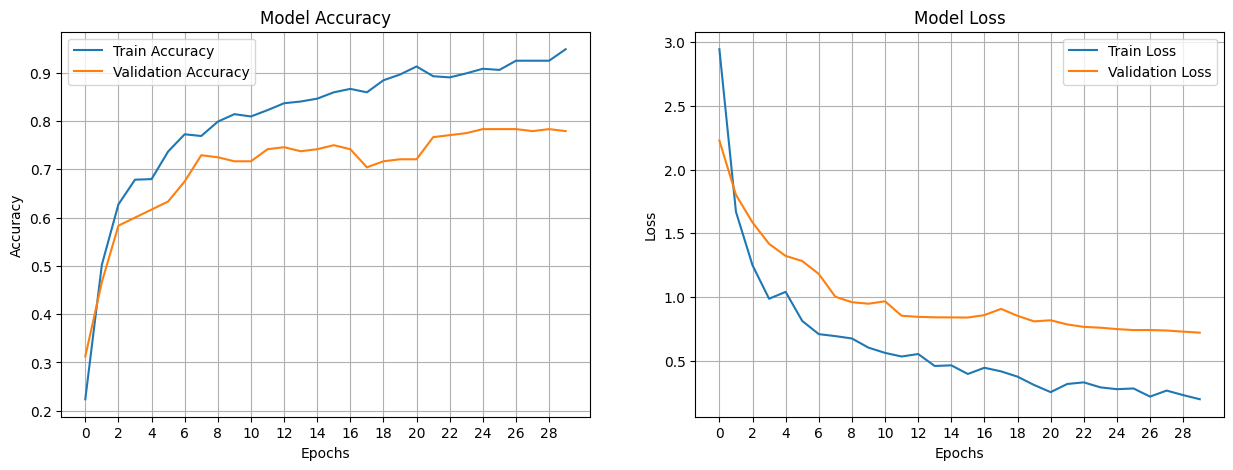

In [73]:
plot_history(h_resnet50)

In [74]:
model_name = 'resnet50_m'
model_path = f"../saved_models/{category}/{model_name}.hdf5"
resnet50_m = load_model(model_path)

train_loss, train_accuracy  = resnet50_m.evaluate_generator(generator_train)
print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = resnet50_m.evaluate_generator(generator_val)
print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.11065814644098282
Training Accuracy: 0.9702380895614624
------------------------------------------------
Validation Loss: 0.7478654384613037
Validation Accuracy: 0.7833333611488342
------------------------------------------------
Training Times: 168.07704639434814 seconds


### Prediction of Test Dataset

Predicting Times: 0.9888017177581787 seconds


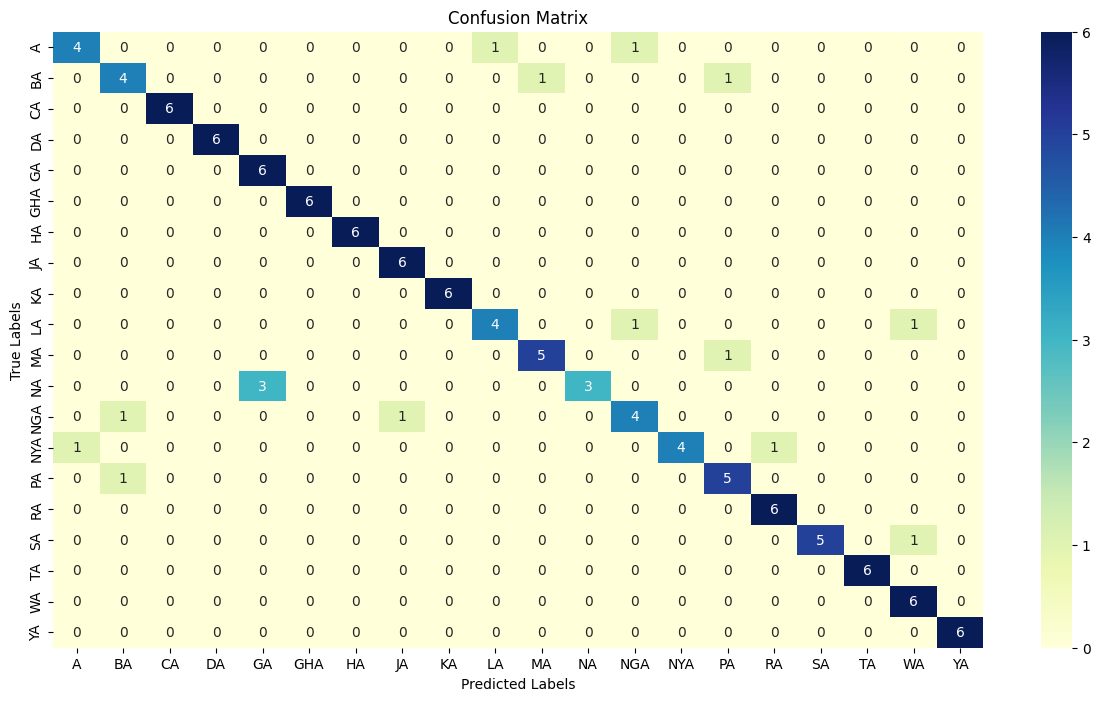

Classification Report:
              precision    recall  f1-score   support

           A       0.80      0.67      0.73         6
          BA       0.67      0.67      0.67         6
          CA       1.00      1.00      1.00         6
          DA       1.00      1.00      1.00         6
          GA       0.67      1.00      0.80         6
         GHA       1.00      1.00      1.00         6
          HA       1.00      1.00      1.00         6
          JA       0.86      1.00      0.92         6
          KA       1.00      1.00      1.00         6
          LA       0.80      0.67      0.73         6
          MA       0.83      0.83      0.83         6
          NA       1.00      0.50      0.67         6
         NGA       0.67      0.67      0.67         6
         NYA       1.00      0.67      0.80         6
          PA       0.71      0.83      0.77         6
          RA       0.86      1.00      0.92         6
          SA       1.00      0.83      0.91         6
    

In [75]:
# Reset generator
generator_test.reset()

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
predictions = resnet50_m.predict_generator(generator_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_loss, test_accuracy = resnet50_m.evaluate_generator(generator_test)

# Ubah prediksi yang diperoleh menjadi label kelas menggunakan invers dari one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)
plot_confusion_matrix(classes_test, predicted_classes)

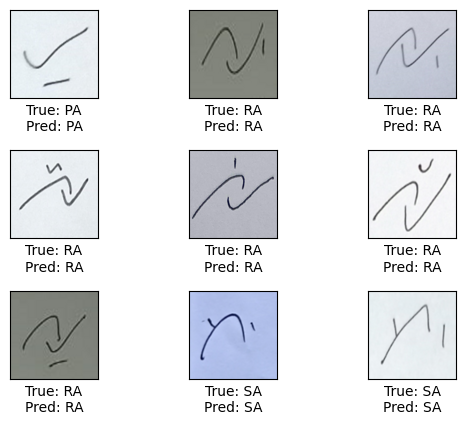

In [76]:
example_success(classes_test, predicted_classes)

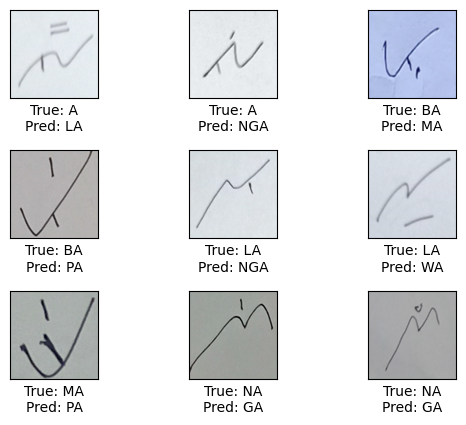

In [77]:
example_errors(classes_test, predicted_classes)

In [78]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]

## ResNet-50 with Fine Tuning

### Build the Model

In [79]:
resnet50_finetune_m = resnet50_new_model(name='resnet50_finetune_m')

for layer in resnet50_finetune_m.layers:
    layer.trainable = True

resnet50_finetune_m.summary()

Model: "resnet50_finetune_m"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                

 ization)                                                                                         
                                                                                                  
 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv3_block1_preact_relu[0][0]'
                                                                 ]                                
                                                                                                  
 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_blo

In [80]:
print_layer_trainable(resnet50_finetune_m)

True:	input_2
True:	conv1_pad
True:	conv1_conv
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_preact_bn
True:	conv2_block1_preact_relu
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_pad
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_out
True:	conv2_block2_preact_bn
True:	conv2_block2_preact_relu
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_pad
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_out
True:	conv2_block3_preact_bn
True:	conv2_block3_preact_relu
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_pad
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	max_pooling2d
True:	conv2_block3_3_conv
True:	conv2_block3_out
True:	conv3_bloc

In [81]:
for layer in resnet50_finetune_m.layers:
    if layer.name.startswith('conv5_'):
        break
    layer.trainable = False

resnet50_finetune_m.summary()

Model: "resnet50_finetune_m"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                

In [82]:
print_layer_trainable(resnet50_finetune_m)

False:	input_2
False:	conv1_pad
False:	conv1_conv
False:	pool1_pad
False:	pool1_pool
False:	conv2_block1_preact_bn
False:	conv2_block1_preact_relu
False:	conv2_block1_1_conv
False:	conv2_block1_1_bn
False:	conv2_block1_1_relu
False:	conv2_block1_2_pad
False:	conv2_block1_2_conv
False:	conv2_block1_2_bn
False:	conv2_block1_2_relu
False:	conv2_block1_0_conv
False:	conv2_block1_3_conv
False:	conv2_block1_out
False:	conv2_block2_preact_bn
False:	conv2_block2_preact_relu
False:	conv2_block2_1_conv
False:	conv2_block2_1_bn
False:	conv2_block2_1_relu
False:	conv2_block2_2_pad
False:	conv2_block2_2_conv
False:	conv2_block2_2_bn
False:	conv2_block2_2_relu
False:	conv2_block2_3_conv
False:	conv2_block2_out
False:	conv2_block3_preact_bn
False:	conv2_block3_preact_relu
False:	conv2_block3_1_conv
False:	conv2_block3_1_bn
False:	conv2_block3_1_relu
False:	conv2_block3_2_pad
False:	conv2_block3_2_conv
False:	conv2_block3_2_bn
False:	conv2_block3_2_relu
False:	max_pooling2d
False:	conv2_block3_3_conv


### Set Parameter Values

In [83]:
OPTIMIZER=Adam(learning_rate=0.001)
LOSS='categorical_crossentropy'
METRICS=['categorical_accuracy']

STEPS_PER_EPOCH = generator_train.n/BATCH_SIZE
VALIDATION_STEPS = generator_val.n/BATCH_SIZE
EPOCHS = 30

model_name = "resnet50_finetune_m"
filepath = f'../saved_models/{category}/{model_name}.hdf5'

checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

CALLBACKS = [reduce_lr, checkpoint, early_stop]

### Training the Model

In [84]:
resnet50_finetune_m.compile(optimizer=OPTIMIZER,loss=LOSS,metrics=METRICS)

start_time = time.time()
h_resnet50_tune = resnet50_finetune_m.fit_generator(generator_train,
                                              epochs=EPOCHS, 
                                              steps_per_epoch=STEPS_PER_EPOCH, 
                                              validation_data=generator_val, 
                                              validation_steps=VALIDATION_STEPS, 
                                              callbacks=CALLBACKS)
end_time = time.time()

Epoch 1/30
26/26 [==============================] - 9s 257ms/step - loss: 2.7353 - categorical_accuracy: 0.2940 - val_loss: 9.3921 - val_categorical_accuracy: 0.0958 - lr: 0.0010
Epoch 2/30
26/26 [==============================] - 5s 206ms/step - loss: 1.4198 - categorical_accuracy: 0.6012 - val_loss: 5.7874 - val_categorical_accuracy: 0.2542 - lr: 0.0010
Epoch 3/30
26/26 [==============================] - 6s 210ms/step - loss: 0.9531 - categorical_accuracy: 0.7345 - val_loss: 3.7012 - val_categorical_accuracy: 0.3500 - lr: 0.0010
Epoch 4/30
26/26 [==============================] - 5s 187ms/step - loss: 0.7163 - categorical_accuracy: 0.8048 - val_loss: 5.5924 - val_categorical_accuracy: 0.2458 - lr: 0.0010
Epoch 5/30
26/26 [==============================] - 5s 201ms/step - loss: 0.4855 - categorical_accuracy: 0.8571 - val_loss: 1.5473 - val_categorical_accuracy: 0.5708 - lr: 0.0010
Epoch 6/30
26/26 [==============================] - 5s 207ms/step - loss: 0.5183 - categorical_accuracy: 

### Model Evaluation

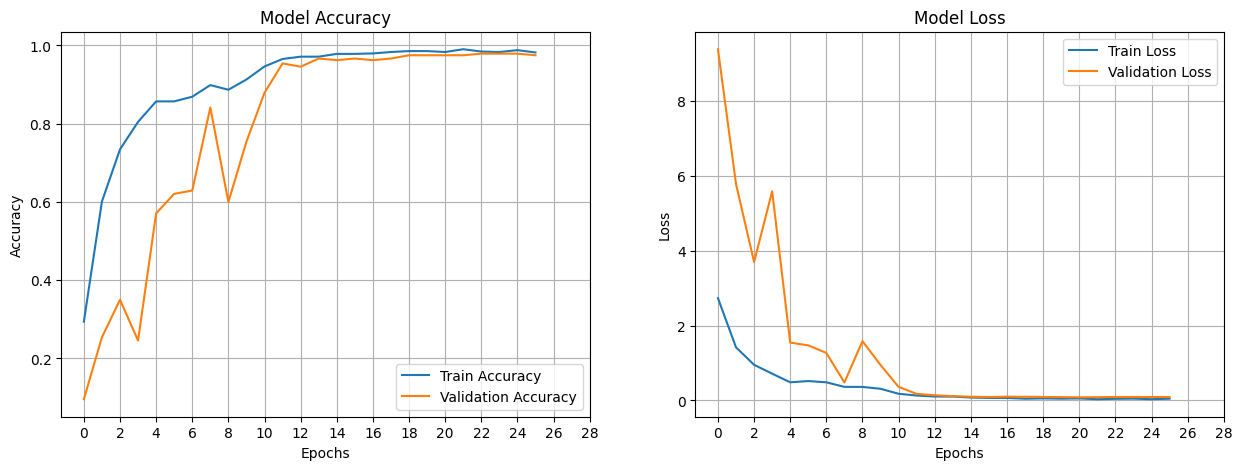

In [85]:
plot_history(h_resnet50_tune)

In [86]:
model_name = 'resnet50_finetune_m'
model_path = f"../saved_models/{category}/{model_name}.hdf5"
resnet50_finetune_m = load_model(model_path)

train_loss, train_accuracy = resnet50_finetune_m.evaluate_generator(generator_train)
print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

val_loss, val_accuracy = resnet50_finetune_m.evaluate_generator(generator_val)
print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.011280910111963749
Training Accuracy: 0.9964285492897034
------------------------------------------------
Validation Loss: 0.0925256535410881
Validation Accuracy: 0.9791666865348816
------------------------------------------------
Training Times: 140.69353652000427 seconds


### Prediction of Test Dataset

Predicting Times: 0.7670085430145264 seconds


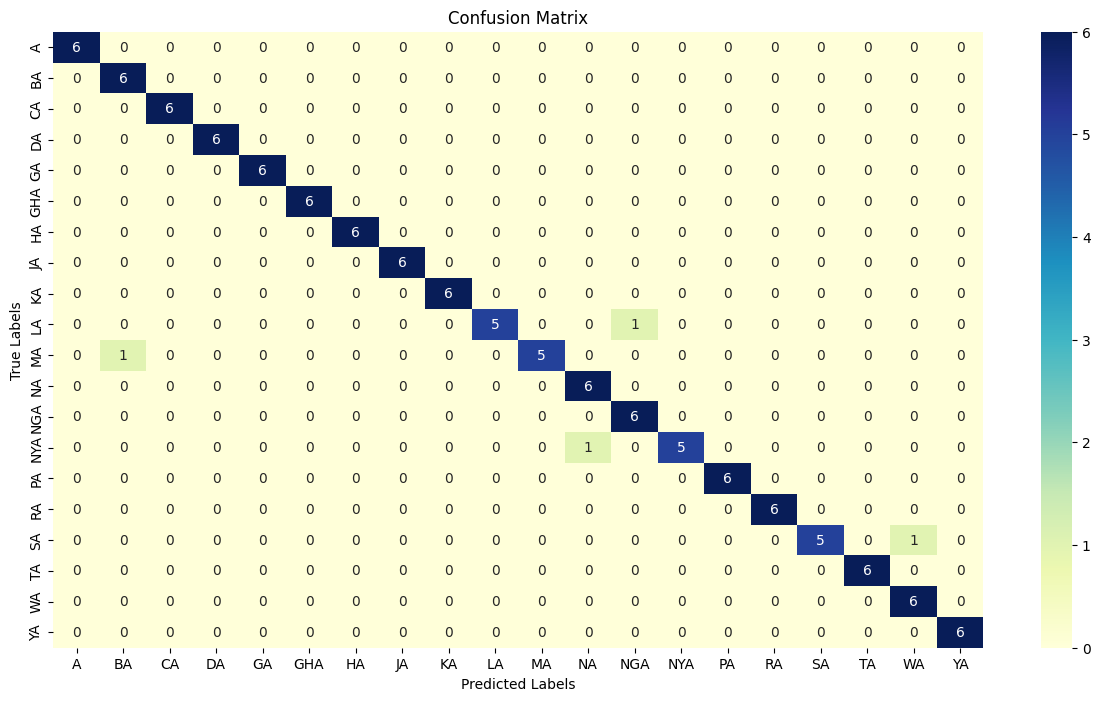

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         6
          BA       0.86      1.00      0.92         6
          CA       1.00      1.00      1.00         6
          DA       1.00      1.00      1.00         6
          GA       1.00      1.00      1.00         6
         GHA       1.00      1.00      1.00         6
          HA       1.00      1.00      1.00         6
          JA       1.00      1.00      1.00         6
          KA       1.00      1.00      1.00         6
          LA       1.00      0.83      0.91         6
          MA       1.00      0.83      0.91         6
          NA       0.86      1.00      0.92         6
         NGA       0.86      1.00      0.92         6
         NYA       1.00      0.83      0.91         6
          PA       1.00      1.00      1.00         6
          RA       1.00      1.00      1.00         6
          SA       1.00      0.83      0.91         6
    

In [87]:
# Reset generator
generator_test.reset()

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
predictions = resnet50_finetune_m.predict_generator(generator_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_loss, test_accuracy = resnet50_finetune_m.evaluate_generator(generator_test)

# Ubah prediksi yang diperoleh menjadi label kelas menggunakan invers dari one-hot encoding
predicted_classes = np.argmax(predictions, axis=1)
plot_confusion_matrix(classes_test, predicted_classes)

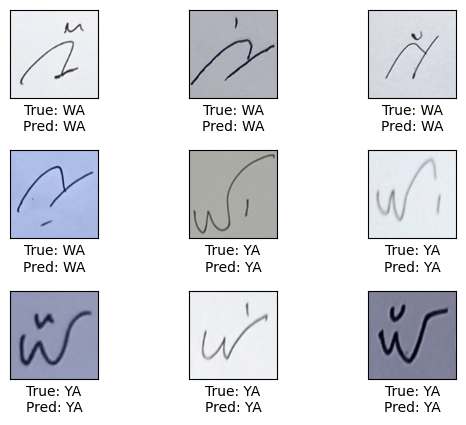

In [88]:
example_success(classes_test, predicted_classes)

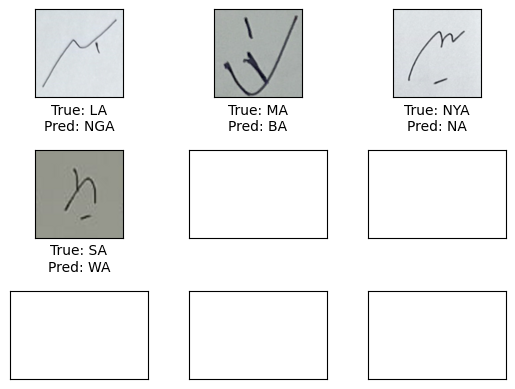

In [89]:
example_errors(classes_test, predicted_classes)

In [90]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]

## ResNet-50 Pretrained as Features Extraction + Random Forest as Classifier

### Build the Model for Features Extraction

In [91]:
resnet50_pretrained_fe = resnet50_m.layers[-5]

resnet50_pretrained_fe = Model(inputs=resnet50_m.input,
                               outputs=resnet50_pretrained_fe.output)

for layer in resnet50_pretrained_fe.layers:
    layer.trainable = False

resnet50_pretrained_fe.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Hyperparameter Tunning GridSearchCV

In [92]:
X_train = resnet50_pretrained_fe.predict(train_images)
X_val = resnet50_pretrained_fe.predict(val_images)
y_train, y_val = classes_train, classes_val

X_train_val = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)], ignore_index=True).values
y_train_val = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)], ignore_index=True).values.reshape(-1)

8/8 [==============================] - 0s 44ms/step


In [93]:
params = {
    'n_estimators' : [100, 200, 300],
}

gs = GridSearchCV(estimator=RandomForestClassifier(random_state=SEED),
                  param_grid=params,
                  scoring=['accuracy', 'neg_log_loss'],
                  refit='accuracy',
                  cv=5,
                  n_jobs=-1)

gs.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300]}, refit='accuracy',
             scoring=['accuracy', 'neg_log_loss'])

In [94]:
grid_search_results(gs)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Parameters: {'n_estimators': 100}
[CV 1/5] accuracy: (test=0.569) log_loss: (test=1.941)
[CV 2/5] accuracy: (test=0.639) log_loss: (test=2.007)
[CV 3/5] accuracy: (test=0.667) log_loss: (test=1.835)
[CV 4/5] accuracy: (test=0.565) log_loss: (test=1.900)
[CV 5/5] accuracy: (test=0.644) log_loss: (test=1.833)

Parameters: {'n_estimators': 200}
[CV 1/5] accuracy: (test=0.602) log_loss: (test=1.929)
[CV 2/5] accuracy: (test=0.708) log_loss: (test=1.820)
[CV 3/5] accuracy: (test=0.704) log_loss: (test=1.837)
[CV 4/5] accuracy: (test=0.625) log_loss: (test=1.891)
[CV 5/5] accuracy: (test=0.676) log_loss: (test=1.815)

Parameters: {'n_estimators': 300}
[CV 1/5] accuracy: (test=0.630) log_loss: (test=1.919)
[CV 2/5] accuracy: (test=0.699) log_loss: (test=1.828)
[CV 3/5] accuracy: (test=0.694) log_loss: (test=1.838)
[CV 4/5] accuracy: (test=0.625) log_loss: (test=1.887)
[CV 5/5] accuracy: (test=0.685) log_loss: (test=1.808)

Best Param

### Training the model

In [95]:
start_time = time.time()
rf_classifier = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators'], random_state=SEED)
rf_classifier.fit(X_train, y_train)
end_time = time.time()

### Model Evaluation

In [96]:
model_name = 'resnet50_pretrained_rf_m'
model_path = f"../saved_models/{category}/{model_name}.pkl"
joblib.dump(rf_classifier, model_path)

resnet50_pretrained_rf_m = joblib.load(model_path)

In [97]:
# Predictions and evaluation on training set
train_predictions = resnet50_pretrained_rf_m.predict(X_train)
train_predictions_prob = resnet50_pretrained_rf_m.predict_proba(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_loss = log_loss(y_train, train_predictions_prob)

# Predictions and evaluation on validation set
val_predictions = resnet50_pretrained_rf_m.predict(X_val)
val_predictions_prob = resnet50_pretrained_rf_m.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_predictions_prob)

print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.36316424966305294
Training Accuracy: 1.0
------------------------------------------------
Validation Loss: 1.8476357355765944
Validation Accuracy: 0.6333333333333333
------------------------------------------------
Training Times: 4.128900527954102 seconds


### Prediction of Test Dataset

4/4 [==============================] - 0s 100ms/step
Predicting Times: 0.4978063106536865 seconds


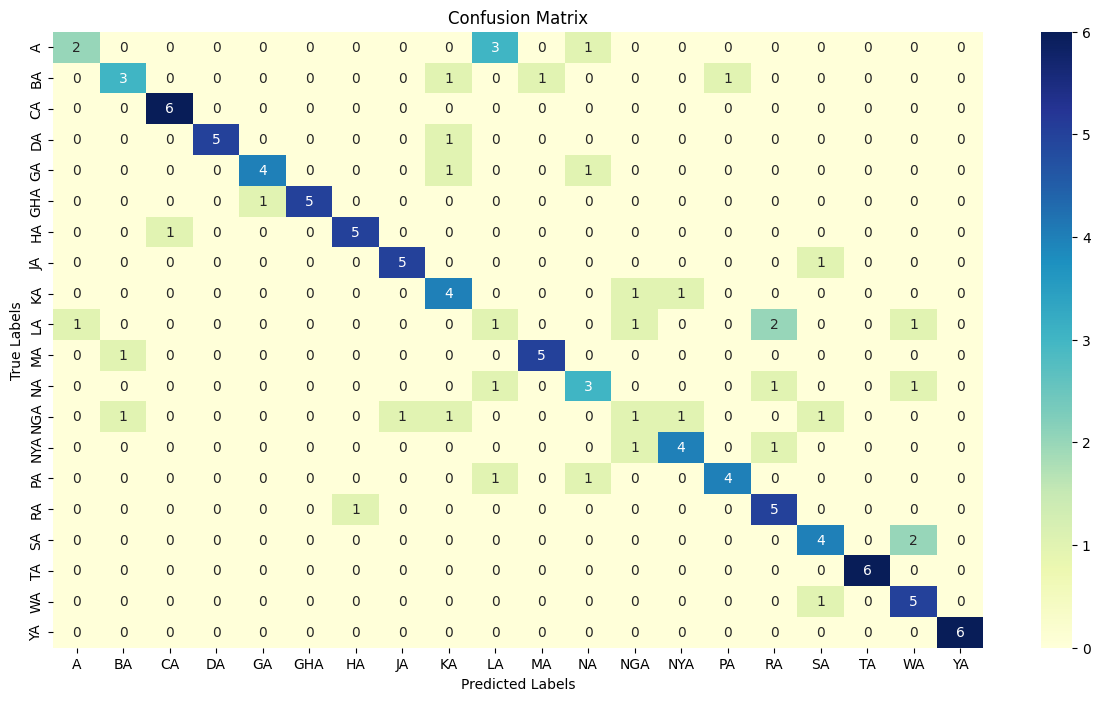

Classification Report:
              precision    recall  f1-score   support

           A       0.67      0.33      0.44         6
          BA       0.60      0.50      0.55         6
          CA       0.86      1.00      0.92         6
          DA       1.00      0.83      0.91         6
          GA       0.80      0.67      0.73         6
         GHA       1.00      0.83      0.91         6
          HA       0.83      0.83      0.83         6
          JA       0.83      0.83      0.83         6
          KA       0.50      0.67      0.57         6
          LA       0.17      0.17      0.17         6
          MA       0.83      0.83      0.83         6
          NA       0.50      0.50      0.50         6
         NGA       0.25      0.17      0.20         6
         NYA       0.67      0.67      0.67         6
          PA       0.80      0.67      0.73         6
          RA       0.56      0.83      0.67         6
          SA       0.57      0.67      0.62         6
    

In [98]:
y_test = classes_test

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
X_test = resnet50_pretrained_fe.predict(test_images)
predictions = resnet50_pretrained_rf_m.predict(X_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_accuracy = accuracy_score(y_test, predictions)
plot_confusion_matrix(y_test, predictions)

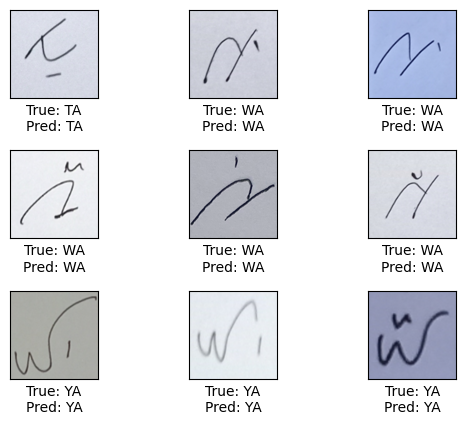

In [99]:
example_success(y_test, predictions)

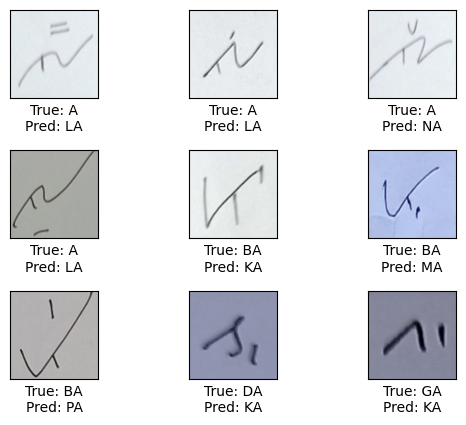

In [100]:
example_errors(y_test, predictions)

In [101]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]

## ResNet-50 Finetuning as Features Extraction + Random Forest as Classifier

### Build the Model for Features Extraction

In [102]:
resnet50_ft_fe = resnet50_finetune_m.layers[-5]

resnet50_ft_fe = Model(inputs=resnet50_finetune_m.input,
                  outputs=resnet50_ft_fe.output)

for layer in resnet50_ft_fe.layers:
    layer.trainable = False

resnet50_ft_fe.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

### Hyperparameter Tunning GridSearchCV

In [103]:
X_train = resnet50_ft_fe.predict(train_images)
X_val = resnet50_ft_fe.predict(val_images)
y_train, y_val = classes_train, classes_val

X_train_val = pd.concat([pd.DataFrame(X_train), pd.DataFrame(X_val)], ignore_index=True).values
y_train_val = pd.concat([pd.DataFrame(y_train), pd.DataFrame(y_val)], ignore_index=True).values.reshape(-1)

8/8 [==============================] - 0s 44ms/step


In [104]:
params = {
    'n_estimators' : [100, 200, 300],
}

gs = GridSearchCV(estimator=RandomForestClassifier(random_state=SEED),
                  param_grid=params,
                  scoring=['accuracy', 'neg_log_loss'],
                  refit='accuracy',
                  cv=5,
                  n_jobs=-1)

gs.fit(X_train_val, y_train_val)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300]}, refit='accuracy',
             scoring=['accuracy', 'neg_log_loss'])

In [105]:
grid_search_results(gs)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Parameters: {'n_estimators': 100}
[CV 1/5] accuracy: (test=0.995) log_loss: (test=0.340)
[CV 2/5] accuracy: (test=1.000) log_loss: (test=0.256)
[CV 3/5] accuracy: (test=0.991) log_loss: (test=0.282)
[CV 4/5] accuracy: (test=0.981) log_loss: (test=0.328)
[CV 5/5] accuracy: (test=0.968) log_loss: (test=0.378)

Parameters: {'n_estimators': 200}
[CV 1/5] accuracy: (test=0.991) log_loss: (test=0.345)
[CV 2/5] accuracy: (test=1.000) log_loss: (test=0.259)
[CV 3/5] accuracy: (test=0.991) log_loss: (test=0.276)
[CV 4/5] accuracy: (test=0.991) log_loss: (test=0.324)
[CV 5/5] accuracy: (test=0.963) log_loss: (test=0.383)

Parameters: {'n_estimators': 300}
[CV 1/5] accuracy: (test=0.995) log_loss: (test=0.346)
[CV 2/5] accuracy: (test=1.000) log_loss: (test=0.258)
[CV 3/5] accuracy: (test=0.991) log_loss: (test=0.272)
[CV 4/5] accuracy: (test=0.995) log_loss: (test=0.321)
[CV 5/5] accuracy: (test=0.972) log_loss: (test=0.382)

Best Param

### Training the model

In [106]:
start_time = time.time()
rf_classifier = RandomForestClassifier(n_estimators=gs.best_params_['n_estimators'], random_state=SEED)
rf_classifier.fit(X_train, y_train)
end_time = time.time()

### Model Evaluation

In [107]:
model_name = 'resnet50_finetune_rf_m'
model_path = f"../saved_models/{category}/{model_name}.pkl"
joblib.dump(rf_classifier, model_path)

resnet50_finetune_rf_m = joblib.load(model_path)

In [108]:
# Predictions and evaluation on training set
train_predictions = resnet50_finetune_rf_m.predict(X_train)
train_predictions_prob = resnet50_finetune_rf_m.predict_proba(X_train)

train_accuracy = accuracy_score(y_train, train_predictions)
train_loss = log_loss(y_train, train_predictions_prob)

# Predictions and evaluation on validation set
val_predictions = resnet50_finetune_rf_m.predict(X_val)
val_predictions_prob = resnet50_finetune_rf_m.predict_proba(X_val)

val_accuracy = accuracy_score(y_val, val_predictions)
val_loss = log_loss(y_val, val_predictions_prob)

print("------------------------------------------------")
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")

print("------------------------------------------------")
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

training_time = end_time - start_time
print("------------------------------------------------")
print("Training Times:", training_time, "seconds")

------------------------------------------------
Training Loss: 0.0909639505126615
Training Accuracy: 1.0
------------------------------------------------
Validation Loss: 0.42286242669286384
Validation Accuracy: 0.9666666666666667
------------------------------------------------
Training Times: 5.034014463424683 seconds


### Prediction of Test Dataset

4/4 [==============================] - 0s 94ms/step
Predicting Times: 0.4274914264678955 seconds


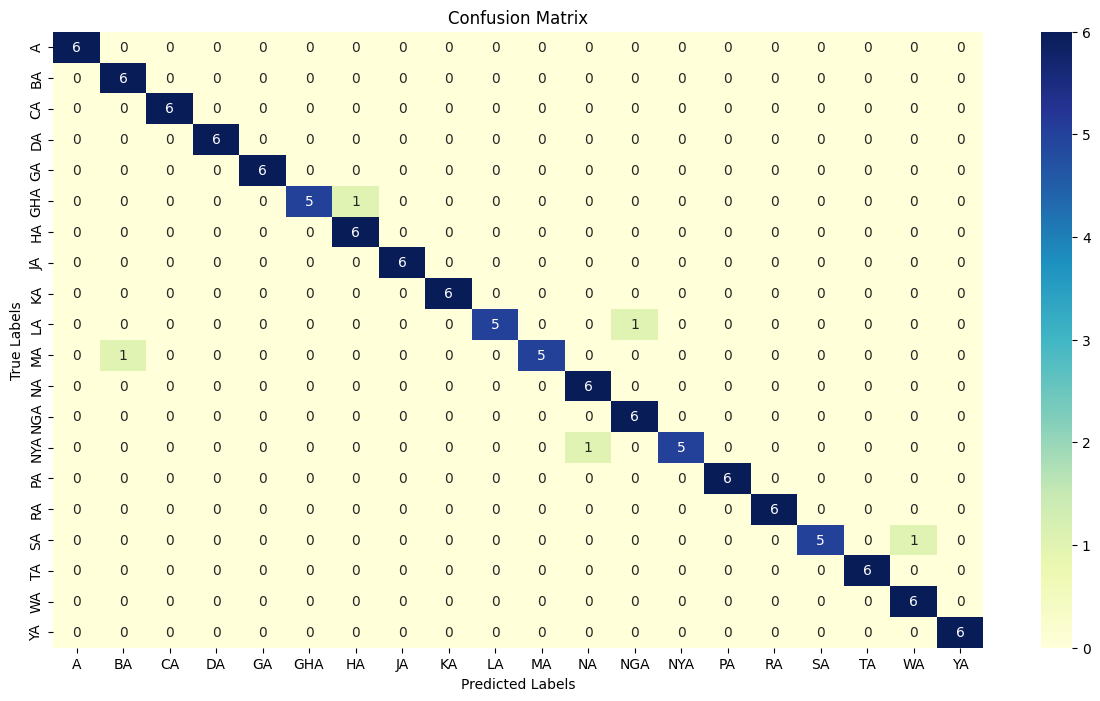

Classification Report:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00         6
          BA       0.86      1.00      0.92         6
          CA       1.00      1.00      1.00         6
          DA       1.00      1.00      1.00         6
          GA       1.00      1.00      1.00         6
         GHA       1.00      0.83      0.91         6
          HA       0.86      1.00      0.92         6
          JA       1.00      1.00      1.00         6
          KA       1.00      1.00      1.00         6
          LA       1.00      0.83      0.91         6
          MA       1.00      0.83      0.91         6
          NA       0.86      1.00      0.92         6
         NGA       0.86      1.00      0.92         6
         NYA       1.00      0.83      0.91         6
          PA       1.00      1.00      1.00         6
          RA       1.00      1.00      1.00         6
          SA       1.00      0.83      0.91         6
    

In [109]:
y_test = classes_test

# Lakukan prediksi menggunakan model yang dimuat
start_time = time.time()
X_test = resnet50_ft_fe.predict(test_images)
predictions = resnet50_finetune_rf_m.predict(X_test)
end_time = time.time()
predicting_time = end_time - start_time
print("Predicting Times:", predicting_time, "seconds")

test_accuracy = accuracy_score(y_test, predictions)

plot_confusion_matrix(y_test, predictions)

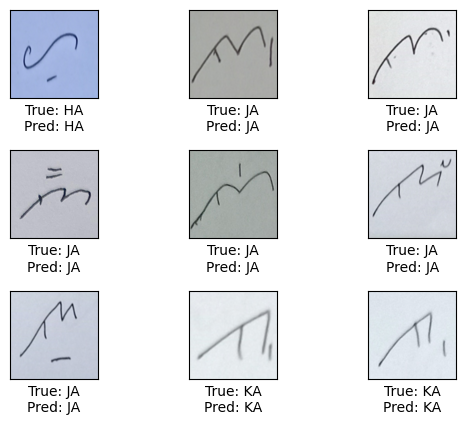

In [110]:
example_success(y_test, predictions)

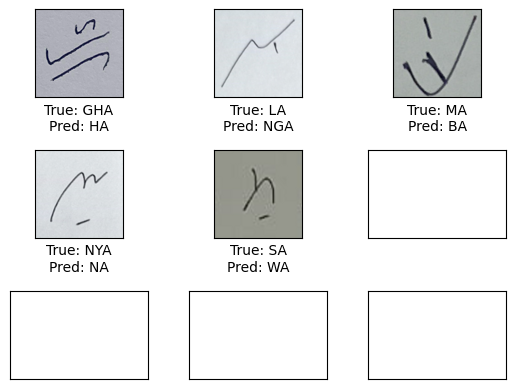

In [111]:
example_errors(y_test, predictions)

In [112]:
accuracy_results[f'{model_name}'] = [train_accuracy, val_accuracy, test_accuracy, training_time, predicting_time]

# Benchmark All Models

In [113]:
df = pd.DataFrame(accuracy_results).T
df.columns = ['Train Accuracy', 'Validation Accuracy', 'Test Accuracy', 'Training Times', 'Prediction Times of Test Set(s)']
df['Prediction Times / Image (s)'] = df['Prediction Times of Test Set(s)']/len(classes_test)
df.round(4)

,Train Accuracy,Validation Accuracy,Test Accuracy,Training Times,Prediction Times of Test Set(s),Prediction Times / Image (s)
vgg16_m,0.9786,0.8667,0.9000,189.1420,4.0566,0.0338
vgg16_finetune_m,0.9857,0.9417,0.9500,175.4949,0.6208,0.0052
vgg16_pretraind_rf_m,1.0000,0.7750,0.8167,3.0996,0.5285,0.0044
vgg16_finetune_rf_m,1.0000,0.9500,0.9417,0.9348,0.5641,0.0047
resnet50_m,0.9702,0.7833,0.8667,168.0770,0.9888,0.0082
resnet50_finetune_m,0.9964,0.9792,0.9667,140.6935,0.7670,0.0064
resnet50_pretrained_rf_m,1.0000,0.6333,0.6917,4.1289,0.4978,0.0041
resnet50_finetune_rf_m,1.0000,0.9667,0.9583,5.0340,0.4275,0.0036


# Prediction an Image

In [114]:
def predict(image_path, model):
    # Load and resize the image using OpenCV.
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (IMG_SIZE))

    # Plot the image.
    plt.imshow(img_resized)
    plt.show()

    # Convert the image to a numpy-array with the proper shape.
    img_array =  np.expand_dims(img_resized, axis=0)/255.

    if type(model).__name__ == 'RandomForestClassifier':
        variable_name = [name for name, var in globals().items() if var is model][0]
        if 'vgg16' in variable_name:
            fe = vgg16_ft_fe.predict(img_array)
        else:
            fe = resnet50_ft_fe.predict(img_array)
        pred = model.predict_proba(fe)
    else:
        # Predict the image.
        pred = model.predict(img_array)
    
    # Get the top 5 predictions.
    top_pred_indices = pred.argsort()[0][-5:][::-1]
    top_pred_probabilities = pred[0][top_pred_indices]
    
    # Decode the output of the model.
    predicted_classes = np.argmax(pred, axis=1)
    predicted_classes = class_names[predicted_classes[0]]

    # Print the predictions.
    print("\nPredicted Class:", predicted_classes)

    # Print top 5 predictions and their probabilities.
    print("\nPrediction Probabilities:")
    for class_idx, probability in zip(top_pred_indices, top_pred_probabilities):
        class_name = class_names[class_idx]
        print(f"{probability * 100:6.2f}% : {class_name}")

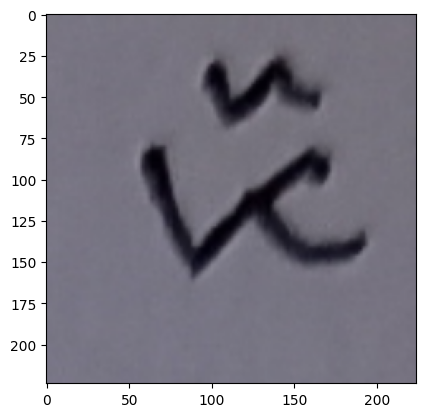

1/1 [==============================] - 1s 514ms/step

Predicted Class: BA

Prediction Probabilities:
 89.11% : BA
  6.94% : MA
  3.67% : CA
  0.24% : TA
  0.01% : GHA


In [115]:
predict(image_path="../dataset/blind dataset/bar_04.png", model=resnet50_finetune_m)